In [3]:
pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 1.8 MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp38-cp38-macosx_10_9_x86_64.whl size=770630 sha256=4e2104dc9e4721cfd3551ab3ad27044381177ed0669ed239ab197ae8d8421849
  Stored in directory: /Users/MamaAmakah/Library/Caches/pip/wheels/20/91/57/2965d4cff1b8ac7ed1b6fa25741882af3974b54a31759e10b6
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [118]:
!pip install cufflinks

     |████████████████████████████████| 81 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 26.5 MB 165 kB/s eta 0:00:01     |██████████████████▌             | 15.3 MB 336 kB/s eta 0:00:34


  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67917 sha256=5e8389f207d0dba4c57606e9796bc83c8b23ab97afccd2528e74d870e8b2ee01
  Stored in directory: /Users/MamaAmakah/Library/Caches/pip/wheels/29/b4/f8/2fd2206eeeba6ccad8167e4e8894b8c4ec27bf1342037fd136
Successfully built cufflinks


In [119]:
# Data manipulation
import numpy as np 
import pandas as pd   
import re

# Data Preprocessing
import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Ignore warnings 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split


# Data visualization
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_style("dark")

# Building recommender systems
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Here we only import the datasets that we need to save memory

In [87]:
movies = pd.read_csv('movies.csv')
imdb_data = pd.read_csv('imdb_data.csv')
tags = pd.read_csv('tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
]links_df = pd.read_csv('links.csv')/

## Viewing the data

In [88]:
# Display the first 5 entries in each dataframe 
display(movies.head())
display(imdb_data.head())
display(tags.head())
display(train.head())

# Count the number of unique entries for features of interest
unique_movies = len(movies['movieId'].unique().tolist())
unique_tags = len(tags['tag'].unique().tolist())
unique_users = len(train['userId'].unique().tolist())
unique_directors = len(imdb_data['director'].unique().tolist())
unique_actors = len(imdb_data['title_cast'].unique().tolist())

# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])

print('number of unique entries for features of interest')
display(unique.transpose())

# Determine and display the min and max ratings received
min_rating = train.rating.min()
max_rating = train.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


number of unique entries for features of interest


,unique_entries
movies,62423
tags,73051
users,162541
directors,11787
actors,17144


Lowest rating: 0.5
Highest rating: 5.0


### Preparing the data for visualization

We select the features we are interested and looking through and put it into a new dataframe.

In [89]:

df = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
#Add colummn for release year
df['year'] = df['title'].str.extract(r"\((\d+)\)", expand=False)
df.head()

,movieId,title_cast,director,plot_keywords,genres,title,year
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995),1995
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995),1995
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995),1995
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995),1995


#### We format the dataset so that we can do some EDA.

We convert datatypes, remove pipes between words, limit the number of keywords and cast members per movie and remove spaces


In [90]:
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

df.head()

,movieId,title_cast,director,plot_keywords,genres,title,year
0,1,"[tomhanks, timallen, donrickles]",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995),1995
1,2,"[robinwilliams, jonathanhyde, kirstendunst]",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995),1995
2,3,"[waltermatthau, jacklemmon, sophialoren]",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995),1995
3,4,"[whitneyhouston, angelabassett, lorettadevine]",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995),1995
4,5,"[stevemartin, dianekeaton, martinshort]",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995),1995


# EDA

Distribution of average ratings

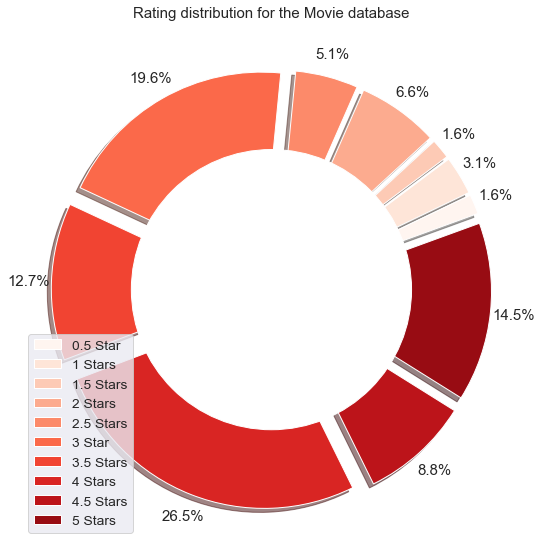

In [91]:
# Merge train with movies to join movie titles and ratings 
ratings = train.merge(movies, on='movieId', how='inner')
#ratings.drop('timestamp', axis=1, inplace=True)

# Count how many ratings are in each category (1 star, 2 star, ect)
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Creating plots 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create colour palette
labels = ['0.5 Star', '1 Stars', '1.5 Stars', '2 Stars', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('Reds')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 shadow=True,
                 startangle=20,
                 pctdistance=1.115,
                 explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display donut plot with legend
plt.legend(pie[0], labels, loc="lower left")
ax.set_title('Rating distribution for the Movie database\n', fontsize=15)
plt.tight_layout()
plt.show()

NOTE:A movie can make it to the top of the list even if only a single user has given it five stars. Normally, a movie that's really a good one gets a higher rating by a large number of users

Distribution of averages

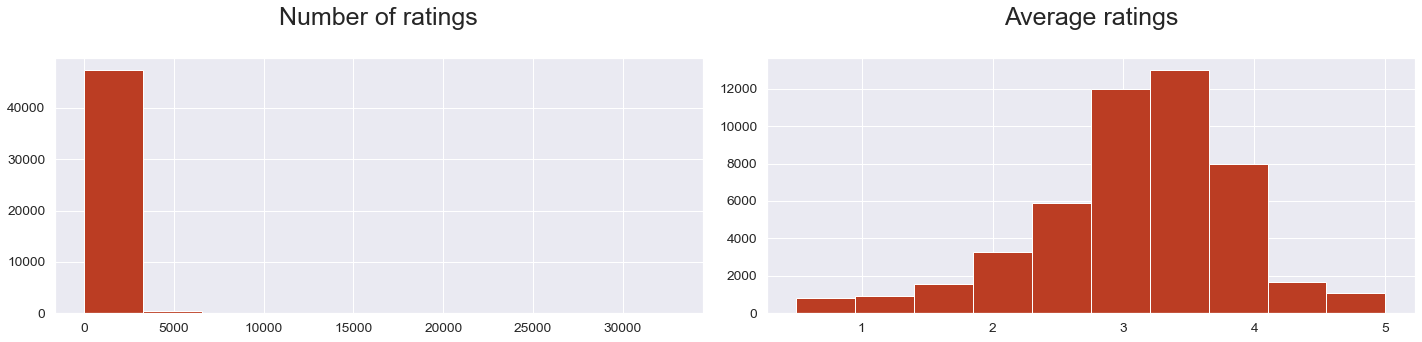

In [92]:
# Determine the average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(ratings.groupby(['title'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count()*ratings.groupby(['title'])['rating'].mean())

# Create a plot of the number of ratings 
f, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].hist(ratings_mean_count['rating_counts'], bins=10, color='#bb3d23')
axarr[0].set_title('Number of ratings\n', fontsize=25)

# Create a plot showing the average ratings distribution 
axarr[1].hist(ratings_mean_count['rating'], bins=10, color='#bb3d23')
axarr[1].set_title('Average ratings\n', fontsize=25)

# Display both plots
plt.tight_layout()
plt.show()

-The ratings are normally distributed and skewed to the right.The ratings seems generally high.
-The mean rating is around 3.

#### Release year

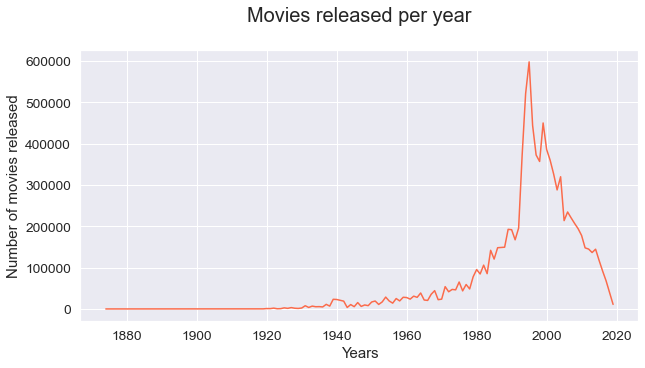

In [93]:
# Extract the release year fron the movie titles
ratings['release_year'] = ratings.title.map(lambda x: re.findall('\d\d\d\d', x))
ratings.release_year = ratings.release_year.apply(lambda x: np.nan if not x else int(x[-1]))
years =  pd.DataFrame(ratings.groupby(['release_year'])['title'].count())
years.rename(columns={'title':'movies released'}, inplace=True)

# Plot the number of movies released per year
plt.figure(figsize=(10,5))
plot = sns.lineplot(data=years, dashes=False, legend=False, palette='Reds_r')

# Add figure labels
plt.xlabel('Years', fontsize=15)
plt.ylabel('Number of movies released', fontsize=15)
plt.title('Movies released per year\n', fontsize=20)

plt.show() 

-There was a huge spike in movie production between 1990 and 2000 which has slowed down significantly in the last few years.

#### Top 10 Users with the most ratings

Text(0, 0.5, 'Number of Ratings')

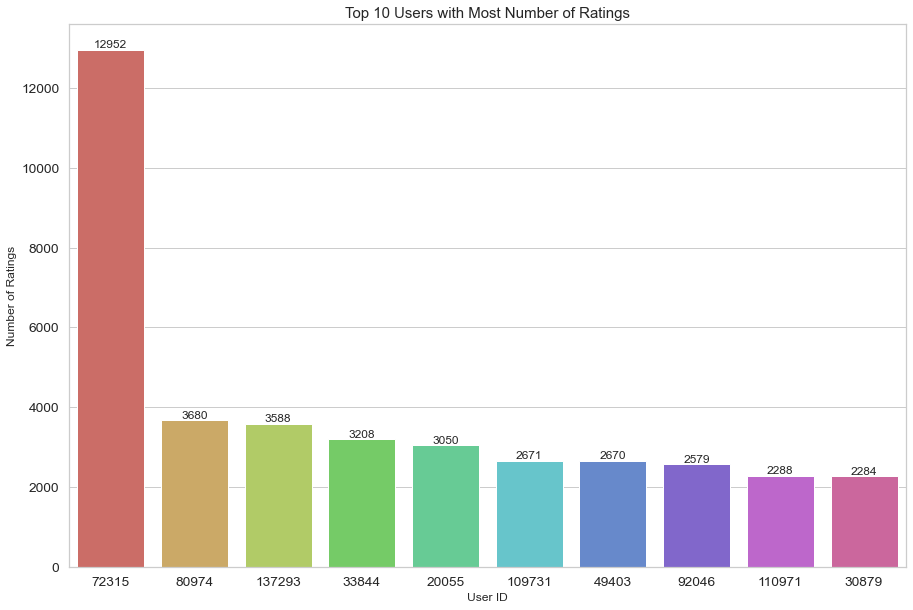

In [94]:
# create figure with white grid style
plt.figure(figsize=(15,10))
sns.set_style("whitegrid") 

# use user id data from train df
# plot barplot
data = train['userId'].value_counts(ascending=False).head(10)
fig = sns.barplot(x=data.index, y=data, order=data.index, palette='hls')

for p in fig.patches:
        fig.text(p.get_x() + p.get_width()/2, p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')

# add title and label
plt.title("Top 10 Users with Most Number of Ratings", size=15)
plt.xlabel("User ID", size=12)
plt.ylabel("Number of Ratings", size=12)

-It seems user 72315 is somekind of a super user as a complete outlier,may actually not even be a person.May be a computer programme

#### Greatest hits: most popular movies

In [95]:
# Extract and display the 10 most popular films in the dataset 
ratings_mean_count = ratings_mean_count.sort_values(by='popularity', ascending=False).head(15)
ratings_mean_count.head(15)

,rating,rating_counts,popularity
title,,,
"Shawshank Redemption, The (1994)",4.417624,32831,145035.0
Pulp Fiction (1994),4.195097,31697,132972.0
Forrest Gump (1994),4.047216,32383,131061.0
"Silence of the Lambs, The (1991)",4.144172,29444,122021.0
"Matrix, The (1999)",4.154253,29014,120531.5
Star Wars: Episode IV - A New Hope (1977),4.111811,27560,113321.5
Schindler's List (1993),4.247625,24004,101960.0
Fight Club (1999),4.227906,23536,99508.0
Star Wars: Episode V - The Empire Strikes Back (1980),4.146236,22956,95181.0


In [97]:
user_ratings = train[['userId','rating',"movieId"]]
user_ratings = user_ratings.merge(movies[['title',"movieId"]], on='movieId', how='inner')
user_ratings = user_ratings.drop(['movieId'], axis = 1)
user_ratings = user_ratings.head(750000) #reducing values

### Trends in genre popularity

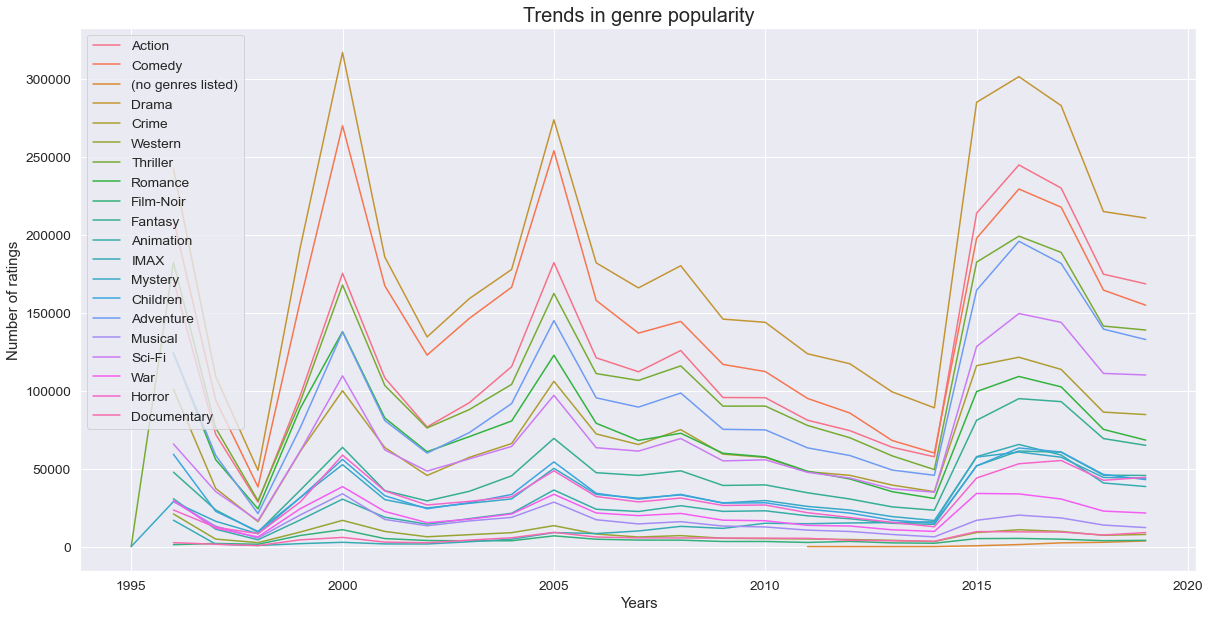

In [98]:
def most_watched(input_df):  
    """"
    This function creates a plot showing the popularity of each genre 
    over the last 50 years.
    
    Input: input_df
           datatype: DataFrame
           
    Output: None
    
    """   
    # Create a copy of the input dataframe and merge it to the movies dataframe
    df = input_df.copy()
    df = df.merge(movies,on='movieId',how='left')
    
    # Create an empty dataframe
    b = pd.DataFrame()
    
    # Extract the timestamps and genres 
    timestamps = [timestamp for timestamp in df.timestamp]
    all_genres = set(','.join([genres.replace('|',',') for genres in df.genres]).split(','))
    
    # Get the number of ratings for each genre for each year since 1970
    for index,genre in enumerate(all_genres):
        s2 = a.astype('Int32')
        a = pd.Series([int((timestamps[i]/31536000)+1970) for i,x in enumerate(df.genres) if genre in x])
        a = a.value_counts()
        b = pd.concat([b,pd.DataFrame({genre:a})],axis=1)
    
    # Plot the trends for each genre on the same line graph 
    plt.figure(figsize=(20,10))
    plot = sns.lineplot(data=b, dashes=False)
      
    # Add plot labels
    plt.title('Trends in genre popularity',fontsize=20)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Number of ratings', fontsize=15)
    
    plt.show()
    
    return

most_watched(train)

There is a huge spike in 2015, this could be because of an increase in users and/or an increase in the number of movies released.

It is also worth noting that the count of movie ratings has gone down across the boards in the last 5 years

### Plot keywords


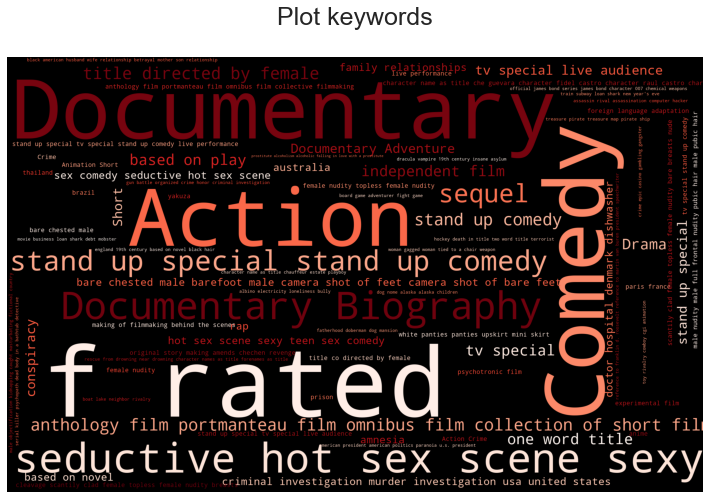

In [99]:
def wordcloud_generator(df, column):  
    """
    This function extracts all the unique keywords in a column
    and counts the number of times each keyword occurs in the column
    while ignoring words that are not meaningful.
    these keywords are then used to generate a word cloud 
    
    Input: df
           datatype: DataFrame
           column
           datatype: str
           
    Output: wordcloud
            Datatype: None
            
    """    
    keyword_counts = {}
    keyword_pair = []
    words = dict()
    
    # list of words that should be ignored
    ignore = ['nan', ' nan', 'nan ', 'seefullsummary', ' seefullsummary', 'seefullsummary ']
    
    # Extract the unique keywords 
    for keyword in [keyword for keyword in df[column] if keyword not in ignore]:
        if keyword in keyword_counts.keys():
            keyword_counts[keyword] += 1
        else:
            keyword_counts[keyword] = 1
     # Pair the keywords with their frequencies
    for word,word_freq in keyword_counts.items():
        keyword_pair.append((word,word_freq))
       
    # Sort the keywords accprding to their frequencies
    keyword_pair.sort(key = lambda x: x[1],reverse=True)
    
    # Make it wordcloud-ready
    for s in keyword_pair:
        words[s[0]] = s[1]
        
    # Create a wordcloud using the top 2000 keywords
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='black', 
                          max_words=2000,
                          max_font_size=110,
                          scale=3,
                          random_state=0,
                          colormap='Reds').generate_from_frequencies(words)

    return wordcloud 

# Plot wordcloud
plot_keywords = wordcloud_generator(df, 'plot_keywords')
f = plt.figure(figsize=(20, 8)) 
plt.imshow(plot_keywords) 
plt.axis('off') 
plt.title('Plot keywords\n', fontsize=25)
plt.show()

Directors

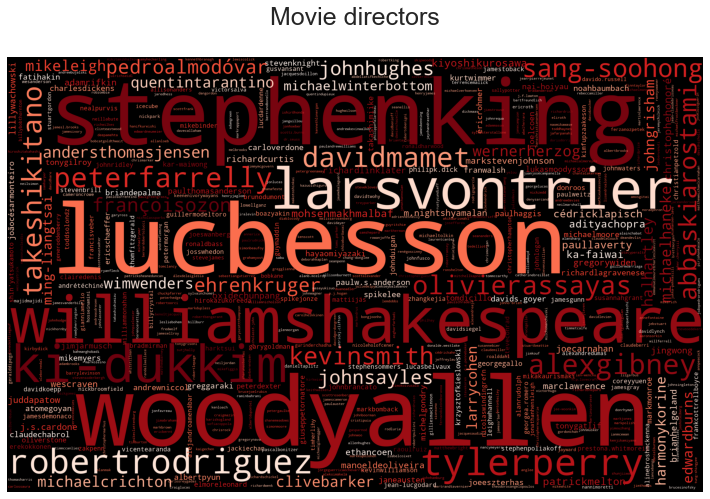

In [100]:
# Generate a WordCloud using the movie directors  
directors = wordcloud_generator(df, 'director')

# Plot the WordCloud 
f = plt.figure(figsize=(20, 8)) 
plt.imshow(directors) 
plt.axis('off') 
plt.title('Movie directors\n', fontsize=25)
plt.show()

Actors

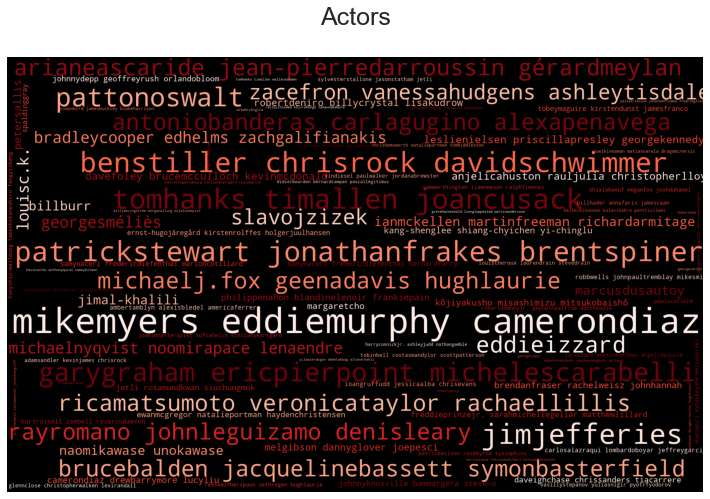

In [101]:
# Generate a wordcloud using the 2000 most frequently occuring actors' names in the dataset
df['title_cast'] = df['title_cast'].apply(lambda x: " ".join(x))
actors = wordcloud_generator(df, 'title_cast')

# plot the WordCloud                        
f = plt.figure(figsize=(20, 8)) 
plt.imshow(actors) 
plt.axis('off') 
plt.title('Actors\n', fontsize=25)
plt.show()

### Memory handling

We delete some of the dataframes we created for eda but are not using anymore to free up space

In [63]:
del top
del tags
del grouped
del ratings
del ratings_mean_count

## The Recommender System

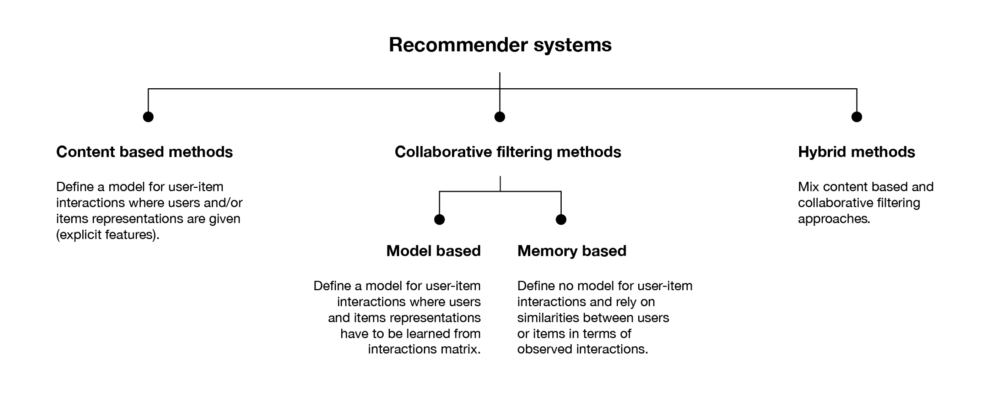

Recommendation engines are a subclass of machine learning which generally deal with ranking or rating products / users. Loosely defined, a recommender system is a system which predicts ratings a user might give to a specific item. These predictions will then be ranked and returned back to the user.

### Content Based Systems

Content based systems generates recommendations based on the users preferences and profile. They try to match users to items which they’ve liked previously. The level of similarity between items is generally established based on attributes of items liked by the user. Unlike most collaborative filtering models which leverage ratings between target user and other users, content based models focus on the ratings provided by the target user themselves. In essence, the content based approach leverages different sources of data to generate recommendations.


##### Item level data source 
— you need a strong source of data associated to the attributes of the item. For our scenario, we have things like book price, num_pages, published_year, etc. The more information you know regarding the item, the more beneficial it will be for your system.

##### User level data source
— you need some sort of user feedback based on the item you’re providing recommendations for. This level of feedback can be either implicit or explicit. In our sample data, we’re working with user ratings of books they’ve read. The more user feedback you can track, the more beneficial it will be for your system.

#### Creating the corpus for each movie

We will be using the cast, director, plot keywords and genre as the metadata for our content based recommender system. These columns will be combined to form the corpus for each film which will then be used to determine the similarity between films.

In [106]:
# Creating an empty column and list to store the corpus for each movie
df['corpus'] = ''
corpus = []

# List of the columns we want to use to create our corpus 
columns = ['title_cast', 'director', 'plot_keywords', 'genres']

# For each movie, combine the contents of the selected columns to form it's unique corpus 
for i in range(0, len(df['movieId'])):
    words = ''
    for col in columns:
        words = words + df.iloc[i][col] + " "        
    corpus.append(words)

# Add the corpus information for each movie to the dataframe 
df['corpus'] = corpus
df.set_index('movieId', inplace=True)

# Drop the columns we don't need anymore to preserve memory
df.drop(columns=['title_cast', 'director', 'plot_keywords', 'genres'], inplace=True)

df.head()

,title,year,corpus
movieId,,,
1,Toy Story (1995),1995,tomhankstimallendonrickles johnlasseter toyriv...
2,Jumanji (1995),1995,robinwilliamsjonathanhydekirstendunst jonathan...
3,Grumpier Old Men (1995),1995,waltermatthaujacklemmonsophialoren markstevenj...
4,Waiting to Exhale (1995),1995,whitneyhoustonangelabassettlorettadevine terry...
5,Father of the Bride Part II (1995),1995,stevemartindianekeatonmartinshort alberthacket...


### Count matrix

We use countvectorizer to convert our corpus into a bag of words

In [108]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df['corpus'])

#### Cosine similarity matrix

Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity.  

In [109]:
cos_sim = cosine_similarity(count_matrix, count_matrix)
print(cos_sim.shape)
cos_sim[:6]

(24866, 24866)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
##view entire matrix
##NB:takes long to run
cos_sim

### Top-N Recommendations

With our content similarity matrix computed, we're now ready to make some recommendations. We will begin by generating a top-N list of movies similar to one which we prompt the system with.

In [110]:
def get_topN_recommendations(title, n=10):
    """
    This function gets the top n recomended movies based on the 
    title of the movie input by the user 
    
    Input: title
           Datatype: str
           
           n (default = 10)
           Datatype: int
    """ 
    # Create a a copy of the input dataframe where the index has been reset
    df1 = df.reset_index()
    
    # Extract the movie titles
    titles = df1['title']
    indices = pd.Series(df1.index, index=df['title'])
    idx = indices[title]
    
    # Get the similarity scores of the top n movies most similar to the user input
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n]
    
    # Exctract the titles of the top n most similar movies  
    movie_indices = [i[0] for i in sim_scores]
    
    return titles.iloc[movie_indices]

get_topN_recommendations('Ice Age (2002)').head(10)

10648                       Ice Age 2: The Meltdown (2006)
16224                                           Rio (2011)
5339                          Hey Arnold! The Movie (2002)
6257                                   Finding Nemo (2003)
6361                               Rugrats Go Wild! (2003)
8258               SpongeBob SquarePants Movie, The (2004)
9958                                     Madagascar (2005)
10257    Wallace & Gromit in The Curse of the Were-Rabb...
10620                                Curious George (2006)
Name: title, dtype: object

The content based method is also extremely memory intensive, for this reason we will not be using this method to make our predictions. Instead we will focus on collaborative filtering.

### Collaborative Filtering Systems

Collaborative filtering is the process of predicting the interests of a user by identifying preferences and information from many users. This is done by filtering data for information or patterns using techniques involving collaboration among multiple agents, data sources, etc. The underlying intuition behind collaborative filtering is that if user A and B have similar taste in a product, then A and B are likely to have similar taste in other products as well.

##### Memory based approaches
— also often referred to as neighbourhood collaborative filtering. Essentially, ratings of user-item combinations are predicted on the basis of their neighbourhoods. This can be further split into user based collaborative filtering and item based collaborative filtering. User based essentially means that likeminded users are going to yield strong and similar recommendations. Item based collaborative filtering recommends items based on the similarity between items calculated using user ratings of those items.

##### Model based approaches
— are predictive models using machine learning. Features associated to the dataset are parameterized as inputs of the model to try to solve an optimization related problem. Model based approaches include using things like decision trees, rule based approaches, latent factor models etc.

###### User based collaborative based filtering

Even though user based collaborative based techniques are powerful, there are few challenges.

-Scalability: In a system where there are many new users, i.e. users with low records of ratings, it is computationally expensive to train the model. These problems arise with Nearest Neighbour algorithms in User based collaborative filtering where these algorithms require computations that grow simultaneously with the increasing numbers of users and items.

-Data Sparsity: Sparsity arises in a system when even the most active users have rated only a marginal number of available items. For example, these users may have experience with even less than 1% of available items making the correlation coefficient less reliable

In [113]:
# Creating a small test dataframe to evaluate our models
tests = train.copy()
tests.drop(['timestamp'], axis=1, inplace=True)
tests = tests.head(10000)

# Creating the training data
reader = Reader(rating_scale=(0.5, 5))
test_data = Dataset.load_from_df(tests[['userId','movieId','rating']], reader)

# Compute similarities between users using cosine distance
sim_options = {"name": "cosine",
               "user_based": True}  

# Evaluate the model 
user = KNNWithMeans(sim_options=sim_options)
cv = cross_validate(user, test_data, cv=5, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1069  1.1010  1.1156  1.1160  1.1121  1.1103  0.0057  
Fit time          3.95    3.82    3.44    3.28    3.11    3.52    0.32    
Test time         0.14    0.03    0.03    0.03    0.03    0.05    0.04    


###### Item-item collaborative based filtering

This method is more stable compared to user based collaborative filtering because the average item has a lot more ratings than the average user. So an individual rating doesn’t impact as much.

The idea of item-item method is to find movies similar to the ones the user already “positively” interacted with. Two items are considered to be similar if most of the users that have interacted with both of them did it in a similar way. This method is said to be “item-centred” as it represents items based on interactions users had with them and evaluates distances between those items.

In [114]:
# Compute similarities between items using cosine distance
sim_options = {"name": "cosine",
               "user_based": False}  

# Fit the KNNwithmeans algorithm to the training set
item_based = KNNWithMeans(sim_options=sim_options)

# Evaluate the model 
cv = cross_validate(item_based, test_data, cv=5, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1041  1.0711  1.0961  1.0889  1.0910  1.0902  0.0109  
Fit time          0.49    0.48    0.56    0.54    0.53    0.52    0.03    
Test time         0.02    0.02    0.03    0.02    0.02    0.02    0.00    


# SVD Model

When it comes to dimensionality reduction, the Singular Value Decomposition (SVD) is a popular method in linear algebra for matrix factorization in machine learning. Such a method shrinks the space dimension from N-dimension to K-dimension (where K<N) and reduces the number of features. SVD constructs a matrix with the row of users and columns of items and the elements are given by the users’ ratings. Singular value decomposition decomposes a matrix into three other matrices and extracts the factors from the factorization of a high-level (user-item-rating) matrix.

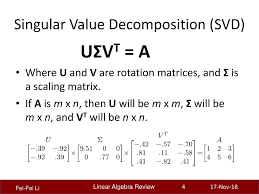

### Train-Test split for svd

Reducing the dataset to train our model on for lower run time

In [120]:
# Load the 100k dataset
#train.drop('timestamp', axis=1, inplace=True)
train_subset = train[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

In [121]:
#fitting the trainset
svd_sub = SVD()
svd_sub.fit(trainset)
svd_pred = svd_sub.test(testset)



In [122]:
# Model Preformance

svd_rmse = accuracy.rmse(svd_pred)

RMSE: 0.9830




Evaluating RMSE of algorithm SVD on 5 split(s)

In [123]:
svd = SVD()
# Run 5-fold cross-validation and print results
svd_cv = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9699  0.9780  0.9775  0.9872  0.9759  0.9777  0.0056  
Fit time          7.68    8.22    8.93    8.52    7.93    8.25    0.44    
Test time         0.37    0.21    0.21    0.18    0.19    0.23    0.07    


In [ ]:
##do not run this cell!! hyperparameter tuning takes some time


param_grid = {'n_epochs':[30,40,50], 
              'n_factors':[200,300,400], 
              'init_std_dev':[0.001, 0.005, 0.05, 0.1], 
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1, joblib_verbose=10)
grid_SVD.fit(data)
print('Best Score is: ')
print(grid_SVD.best_score['rmse'])
print('Best Parameters are: ')
print(grid_SVD.best_params['rmse'])

In [126]:
#using parameters from the parameter tuning

svd_test = SVD(n_epochs = 38, n_factors = 300, init_std_dev = 0.005, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

RMSE: 0.9734


### Submission

In [128]:
# Train the model on the entire dataset 
##takes a while to run the epochs

reader = Reader(rating_scale=(train['rating'].min(), train['rating'].max()))
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_epochs = 38, n_factors = 300, init_std_dev = 0.005, random_state=42, verbose=True)
svd.fit(trainset)


# Make predictions using the trained model
pred = [svd.predict(test.userId[i],test.movieId[i]).est for i in test.index]
test['rating'] = pred

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37


In [130]:
# Create the csv file for submission
test['Id'] = test['userId'].astype(str)+'_'+test['movieId'].astype(str)
test = test[['Id','rating']]
test.to_csv('svd_submission1.csv', index=False)

In [ ]:
test.head()